## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Read CSV files

In [2]:
# Read All Olist files
# Orders
orders = pd.read_csv("D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/olist_orders_dataset.csv")

# Payments
payments = pd.read_csv("D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/olist_order_payments_dataset.csv")

# Products
products = pd.read_csv("D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/olist_products_dataset.csv")

# Customers
Customers = pd.read_csv("D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/olist_customers_dataset.csv")

# Order items
Order_items = pd.read_csv("D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/olist_order_items_dataset.csv")


# Join products with order_items on product_ID then join them to Orders on order_id and then join them to customers on customer_id

## Data preprocessing and cleaning

In [3]:
# Check if order_id is unique or not
is_Order_id_unique = not orders['order_id'].duplicated().any()

if is_Order_id_unique:
    print("The 'Order_id' column in 'Orders' table is unique.")
else:
    print("The 'Order_id' column in 'Orders' table contains duplicate values.")
    
    
# Check if 'product_id' column has any duplicates in the 'products' table
is_product_id_unique = not products['product_id'].duplicated().any()

if is_product_id_unique:
    print("The 'product_id' column in the 'products' table is unique.")
else:
    print("The 'product_id' column in the 'products' table contains duplicate values.")

    
# Check if 'customer_id' column has any duplicates in the 'Customers' table
is_customer_id_unique = not Customers['customer_id'].duplicated().any()

if is_customer_id_unique:
    print("The 'customer_id' column in the 'Customers' table is unique.")
else:
    print("The 'customer_id' column in the 'Customers' table contains duplicate values.")
    
# Check if 'order_id' column has any duplicates in the 'Order_items' table
is_order_id_unique = not Order_items['order_id'].duplicated().any()

if is_order_id_unique:
    print("The 'order_id' column in the 'Order_items' table is unique.")
else:
    print("The 'order_id' column in the 'Order_items' table contains duplicate values.")

    
# Check if 'order_id' column has any duplicates in the 'Order_items' table
is_order_id_unique = not payments['order_id'].duplicated().any()

if is_order_id_unique:
    print("The 'order_id' column in the 'payments' table is unique.")
else:
    print("The 'order_id' column in the 'payments' table contains duplicate values.")
    

The 'Order_id' column in 'Orders' table is unique.
The 'product_id' column in the 'products' table is unique.
The 'customer_id' column in the 'Customers' table is unique.
The 'order_id' column in the 'Order_items' table contains duplicate values.
The 'order_id' column in the 'payments' table contains duplicate values.


In [4]:
# Keep only 'product_id' and 'product_category_name' columns in products table
products = products[ ['product_id', 'product_category_name']]

# Convert 'order_purchase_timestamp' to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Replace top Product Category names to English
products['product_category_name'] = products['product_category_name'].replace({
'automotivo' : 'Automotive'
,'beleza_saude' : 'beauty_health'
,'cama_mesa_banho' : 'bed table bath'
,'esporte_lazer' : 'leisure_sport'
,'ferramentas_jardim' : 'garden_tools'
,'informatica_acessorios' : 'informatica_acessorios'
,'moveis_decoracao' : 'furniture_decoration'
,'relogios_presentes' : 'gift_watches'
,'telefonia' : 'telephony'
,'utilidades_domesticas' : 'housewares'}, regex=True)


# Data Modelling

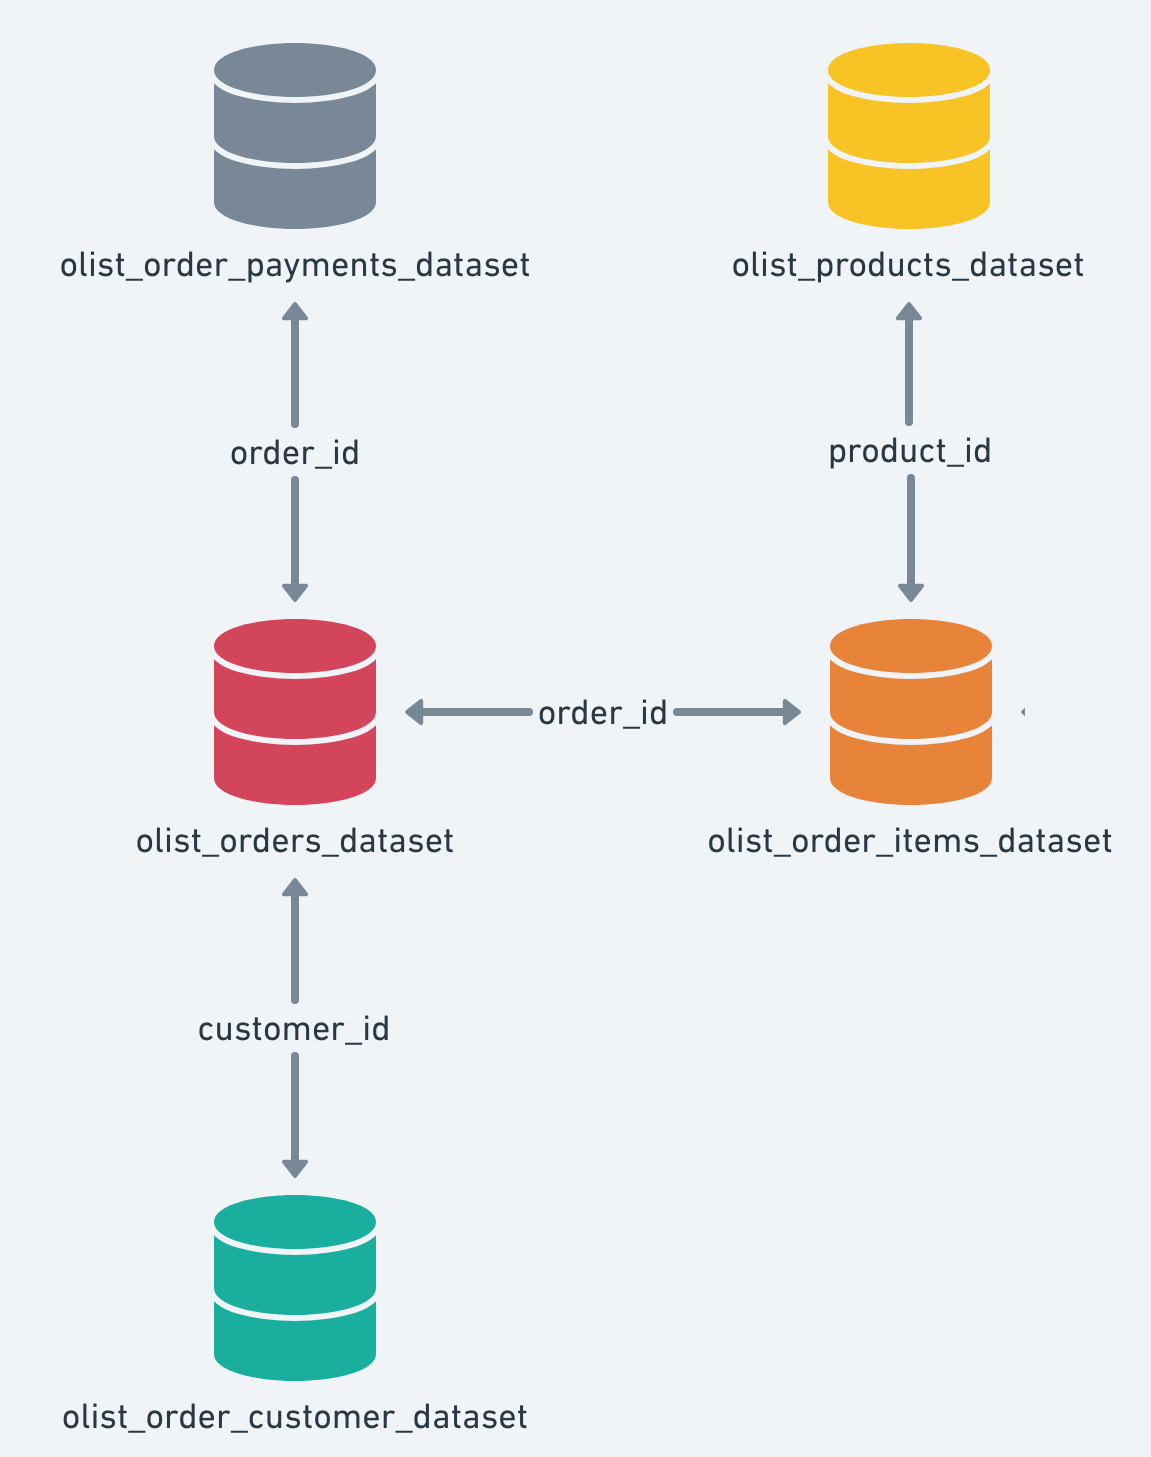

In [5]:
Image("D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/datamodel.png",width=500)

In [7]:
# The order ID in the payment file is distributed across multiple payment types, and we are consolidating all the payments at the order ID level
payments_aggregated = payments.groupby('order_id')['payment_value'].sum().reset_index()

# Merge 'payment_aggregated' with 'orders' on 'order_id'
merged_data = orders.merge(payments_aggregated, on='order_id', how='left')

# Join 'products' with 'Order_items' on 'product_id'
merged_products_order_items = products.merge(Order_items, on='product_id', how='inner')

# Join the result of the first join with 'orders' on 'order_id'
merged_products_order_items_orders = merged_products_order_items.merge(orders, on='order_id', how='inner')

# Join the result of the second join with 'Customers' on 'customer_id'
merged_customer_product_data = merged_products_order_items_orders.merge(Customers, on='customer_id', how='inner')

# Group by 'customer_unique_id' and find the minimum and maximum 'order_purchase_timestamp'
customer_purchase_range = merged_customer_product_data.groupby('customer_unique_id')['order_purchase_timestamp'].agg(['min', 'max'])

# Rename the columns for clarity
customer_purchase_range.columns = ['min_purchase_timestamp', 'max_purchase_timestamp']

# Reset the index to make 'customer_unique_id' a regular column
customer_purchase_range = customer_purchase_range.reset_index()

# Join the result of the second join with 'Customers' on 'customer_id'
final_merged_data = merged_customer_product_data.merge(customer_purchase_range, on='customer_unique_id', how='inner')

# Export the merged data into csv file to provide as an input to PowerBI
final_merged_data.to_csv('D:/Desktop/Resume/2023-24/RobertWalters/Brazilian E-Commerce Public Data/Olist.csv', index=False))

## 1. Gross Revenue by month

#### order_status =  "Processing," "unavailable," "canceled," "created," and "approved" are excluded as they are typically not considered in the gross revenue calculation because they represent different stages of order processing and do not necessarily indicate that a sale has been completed. 

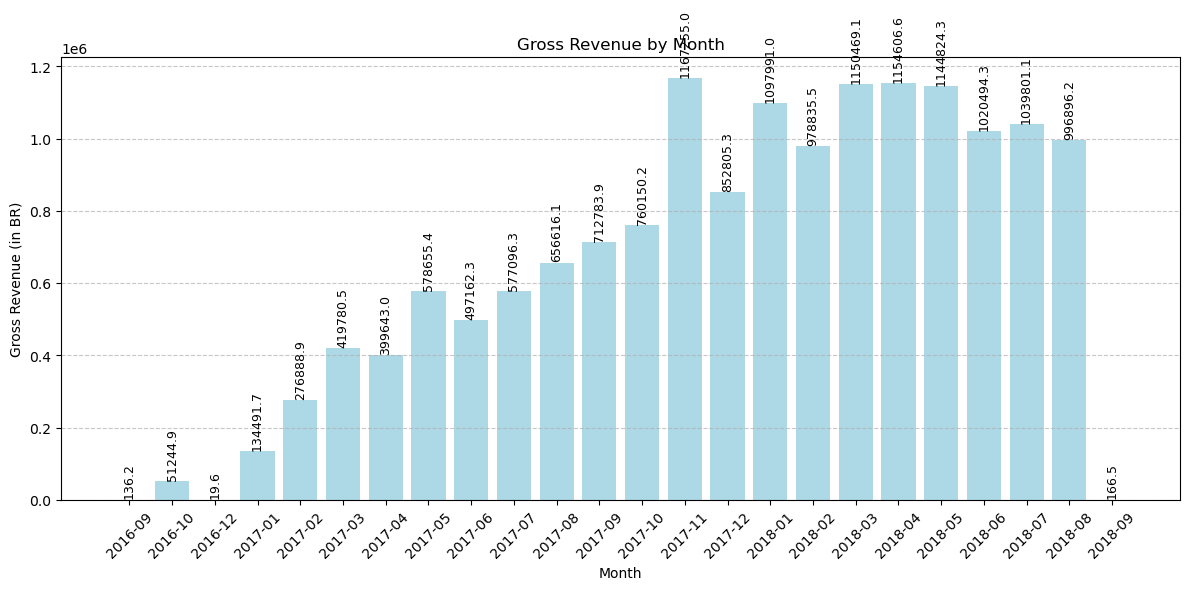

In [10]:

# Keeps rows where 'order_status' is 'delivered','invoiced','shipped'
Orders_inscope = merged_data[merged_data['order_status'].isin(['delivered','invoiced','shipped'])]

Orders_inscope = Orders_inscope.copy()

# Extract the month from the 'order_purchase_timestamp' column
Orders_inscope['order_month'] = Orders_inscope['order_purchase_timestamp'].dt.to_period('M')

# Group by month and calculate gross revenue
monthly_revenue = Orders_inscope.groupby('order_month')['payment_value'].sum()

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_revenue.index.astype(str), monthly_revenue, color='lightblue')

# Add values to the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9,rotation = 90)

plt.title('Gross Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Gross Revenue (in BR)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


# 2. Top selling product in 2018

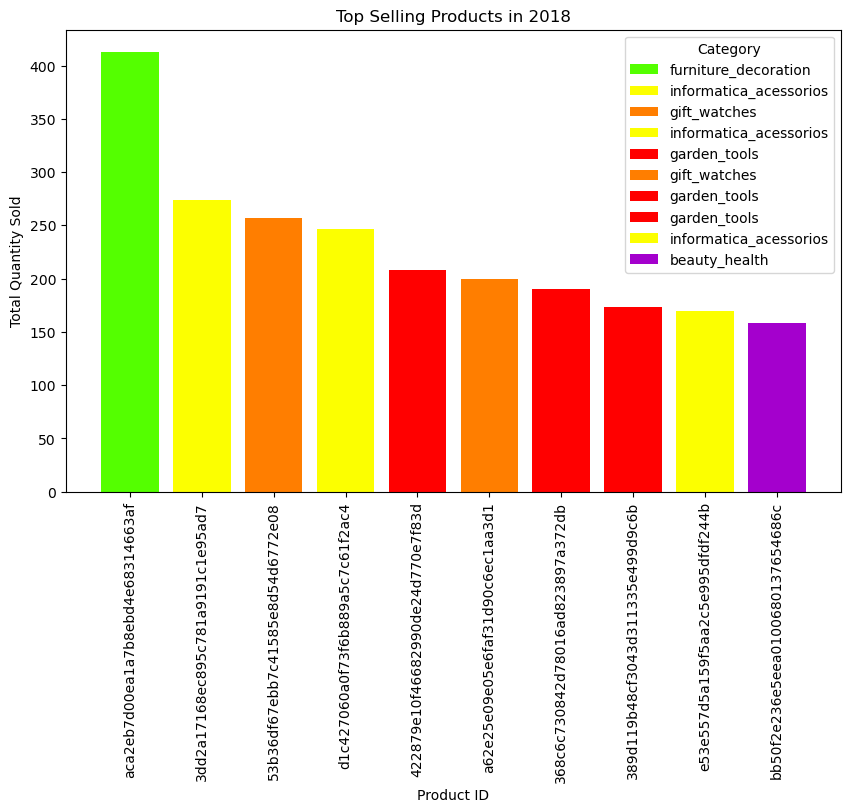

In [11]:
# Filter orders placed in 2018
orders_2018 = final_merged_data[final_merged_data['order_purchase_timestamp'].dt.year == 2018]

# Group order items by product and calculate total quantity sold
top_selling_items_2018 = orders_2018.groupby('product_id')['order_item_id'].count().reset_index()
top_selling_items_2018.columns = ['product_id', 'total_quantity_sold']

# Merge with the 'category' column to get category information
top_selling_items_2018 = top_selling_items_2018.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')


# Sort the products by total quantity sold in descending order to find the top-selling items
top_selling_items_2018 = top_selling_items_2018.sort_values(by='total_quantity_sold', ascending=False)

unique_categories = top_selling_items_2018['product_category_name'].unique()
# Generate a list of unique colors for each category
unique_colors = plt.cm.get_cmap('prism_r',len(unique_categories))

# Plot the bar chart with different colors for each product and category
plt.figure(figsize=(10, 6))
for i, row in top_selling_items_2018[:10].iterrows():  # Select the top 10 products
    category_color = unique_colors(np.where(unique_categories == row['product_category_name'])[0])
    plt.bar(row['product_id'], row['total_quantity_sold'], color=category_color, label=row['product_category_name'])

plt.xlabel('Product ID')
plt.ylabel('Total Quantity Sold')
plt.title('Top Selling Products in 2018')
plt.xticks(rotation=90)

# Create a legend
plt.legend(title='Category', loc='upper right')
plt.show()

## By Category

In [12]:
top_selling_items_2018_C.head(10)

NameError: name 'top_selling_items_2018_C' is not defined

In [ ]:
# Group order items by product category and calculate total quantity sold
top_selling_items_2018_C = orders_2018.groupby('product_category_name')['order_item_id'].count().reset_index()
top_selling_items_2018_C.columns = ['product_category_name', 'total_quantity_sold']

# Sort the products by total quantity sold in descending order to find the top-selling items
top_selling_items_2018_C = top_selling_items_2018_C.sort_values(by='total_quantity_sold', ascending=False)

#unique_categories = top_selling_items_2018_C['product_category_name'].unique()
# Generate a list of unique colors for each category
#unique_colors = plt.cm.get_cmap('prism',len(unique_categories))

# Plot the bar chart with different colors for each product and category
plt.figure(figsize=(10, 6))
for i, row in top_selling_items_2018_C[:10].iterrows():  # Select the top 10 products
    category_color = unique_colors(np.where(unique_categories == row['product_category_name'])[0])
    plt.bar(row['product_category_name'], row['total_quantity_sold'], color=category_color, label=row['product_category_name'])

plt.xlabel('Product Cateogry')
plt.ylabel('Total Quantity Sold')
plt.title('Top Selling Products Categories in 2018')
plt.xticks(rotation=90)

# Create a legend
plt.legend(title='Category', loc='upper right')
plt.show()

# Trendline of product cateogry in 2018

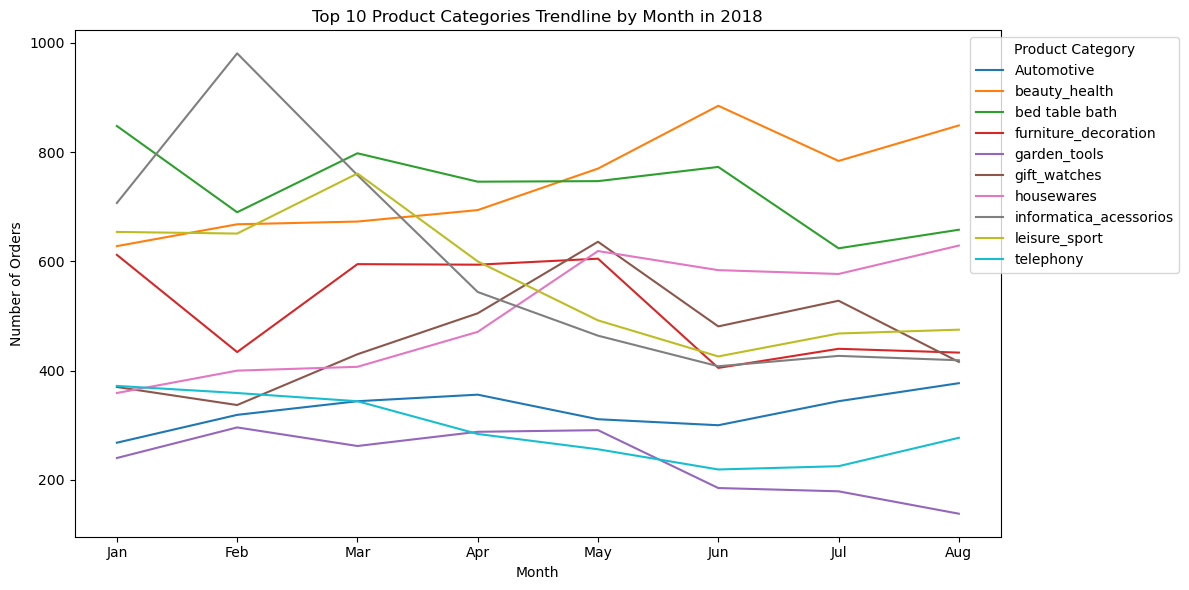

In [13]:
orders_2018 = orders_2018.copy()
# Get year and month information
orders_2018['order_year'] = orders_2018['order_purchase_timestamp'].dt.year
orders_2018['order_month'] = orders_2018['order_purchase_timestamp'].dt.month

# Get count by product category, order_year, month
category_month_counts = orders_2018.groupby(['product_category_name', 'order_year', 'order_month']).size().reset_index(name='order_count')

# Get top 10 categories
top_10_categories = category_month_counts.groupby('product_category_name')['order_count'].sum().nlargest(10).index.tolist()
top_10_category_data = category_month_counts[category_month_counts['product_category_name'].isin(top_10_categories)]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_10_category_data, x='order_month', y='order_count', hue='product_category_name')
plt.title('Top 10 Product Categories Trendline by Month in 2018')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 9), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
plt.legend(title='Product Category', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()